# 階層ベイズモデル

In [42]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
from graphviz import Digraph
from patsy import dmatrix

In [43]:
filepath = '../../../../data/processed/df_filtered_5years.xlsx'
df = pd.read_excel(filepath).drop(columns='special')
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df.dropna(inplace=True)

# 四分位範囲（IQR）を計算
Q1 = df['population_change_rate'].quantile(0.25)
Q3 = df['population_change_rate'].quantile(0.75)
IQR = Q3 - Q1

# 外れ値の定義
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を除外
df_filtered = df[(df['population_change_rate'] >= lower_bound) & (df['population_change_rate'] <= upper_bound)]
# 重複を除外
df_filtered = df_filtered.drop_duplicates(subset=['year', 'island_id'])

/tmp/ipykernel_3183/3527350173.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()


# Hierarchical Bayesian Model (HBM)

$$
PopulationChangeRate_{it} = \mu \\
\mu = \beta_{0} + \beta_{1} \times Bridge_{it} + \beta_{2} \times Income_{it} + Island_{i} + Year_t + \epsilon_{it} \\

PopulationChangeRate \sim N(\mu, \sigma) \\
\beta_{0} \sim N(\mu_{\beta_{0}}, \sigma_{\beta_{0}}) \\
\beta_{1} \sim N(\mu_{\beta_{1}}, \sigma_{\beta_{1}}) \\
\beta_{2} \sim N(\mu_{\beta_{2}}, \sigma_{\beta_{2}}) \\
$$

In [45]:
formula = 'dummy_after_bridge_opened + log_income'
response_var = 'population_change_rate'
group_var = 'island_id'

X = dmatrix(formula, data=df_filtered, return_type='dataframe')
y = df_filtered[response_var]
groups = pd.Categorical(df_filtered[group_var])
group_codes = groups.codes
n_groups = len(groups.categories)

In [48]:
X.shape[]

(558, 3)

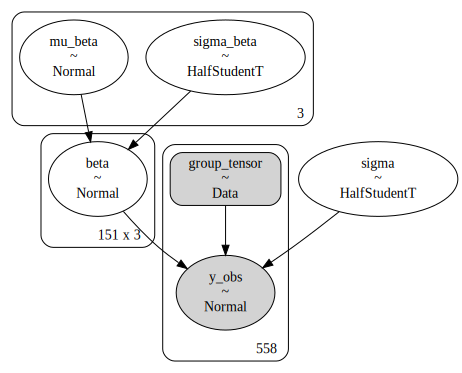

In [61]:
with pm.Model() as model:
    # coord = pm.Data('coord', df_filtered[['island_id', 'year']])
    # Hyper-priors
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=100, shape=3)
    sigma_beta = pm.HalfStudentT('sigma_beta', nu=3, sigma=100, shape=3)

    # # Priors
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=(n_groups, 3))

    # 各サンプルのグループに対応する係数を選択
    group_tensor = pm.Data('group_tensor', groups)
    beta_group = beta[group_tensor]

    # linear model
    mu = pm.math.dot(X, beta_group.T).sum(axis=1)

    # Likelihood
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

# モデルの視覚化
graph = pm.model_to_graphviz(model)
graph.render(filename='../../../visualization/graphviz/hbm_population_change_rate', format='png', cleanup=True)
graph

In [62]:
with model:
    idata = pm.sample(
        draws=2000,
        tune=1000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
    )

IndexError: index 151 is out of bounds for axis 0 with size 151
Apply node that caused the error: AdvancedSubtensor1(beta, group_tensor)
Toposort index: 16
Inputs types: [TensorType(float64, shape=(151, 3)), TensorType(int32, shape=(None,))]
Inputs shapes: [(151, 3), (558,)]
Inputs strides: [(24, 8), (4,)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Transpose{axes=[1, 0]}(AdvancedSubtensor1.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    result = self._run_cell(
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    result = runner(coro)
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3183/2570693692.py", line 12, in <module>
    beta_group = beta[group_tensor]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

### アウトプットの保存

In [9]:
az.to_netcdf(idata, 'hbm_population_change_rate.nc')

'hbm_population_change_rate.nc'

## 結果の表示

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


KeyboardInterrupt: 

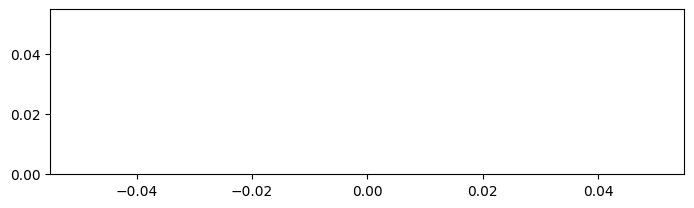

In [28]:
az.plot_trace(idata, figsize=(18, 15))  # サイズを調整
az.summary(idata)